In [85]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision.models import resnet18
from torch.utils.data import DataLoader, sampler
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [53]:
# Basic transforms
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
mean = torch.tensor([0.4914, 0.4822, 0.4465])  # CIFAR-10 mean
std = torch.tensor([0.2023, 0.1994, 0.2010])   # CIFAR-10 std

# CIFAR-10 with train/val/test split
NUM_TRAIN = 45000
NUM_VAL = 5000

cifar10_train = dset.CIFAR10('./data', train=True, download=True, transform=transform)
cifar10_test = dset.CIFAR10('./data', train=False, download=True, transform=transform)

# Create train/val/test loaders
train_loader = DataLoader(
    cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))
)
val_loader = DataLoader(
    cifar10_train, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL))
)
test_loader = DataLoader(cifar10_test, batch_size=128)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [54]:
# Add noise to CIFAR-100

class GaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return tensor + torch.randn(tensor.size()) * self.std + self.mean

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class MaskingNoise(object):
  def __init__(self, prob, mean=mean, std=std):
    mean=torch.tensor(mean).view(3,1,1)
    std=torch.tensor(std).view(3,1,1)
    self.prob = prob
    self.black = (0-mean)/std

  def __call__(self, tensor):
    mask = torch.rand(tensor.shape[-2:])
    return self.black * (mask<self.prob)+tensor*(mask>self.prob)

  def __repr__(self):
    return self.__class__.__name__ + '(prob={0})'.format(self.prob)

class SaltPepperNoise(object):
  def __init__(self, prob, mean=mean, std=std):
    mean=torch.tensor(mean).view(3,1,1)
    std=torch.tensor(std).view(3,1,1)
    self.prob = prob
    self.black = (0-mean)/std
    self.white = (1-mean)/std

  def __call__(self, tensor):
    mask = torch.rand(tensor.shape[-2:])
    mask2 = torch.logical_and(self.prob / 2 <= mask, mask <= (1-self.prob/2))
    return self.black * (mask<(self.prob/2)) + self.white * (mask>(1-self.prob/2)) + tensor*mask2

  def __repr__(self):
    return self.__class__.__name__ + '(prob={0})'.format(self.prob)

class NoisyDataset(dset.CIFAR100):
  def __init__(self, root, train=True, transform=transform, download=True, noise_model=None):
    super().__init__(root=root, train=train, transform=transform, download=download)
    self.noise_model = noise_model

  def __getitem__(self, index):
    img, target = super().__getitem__(index)
    if self.noise_model is not None:
        noisy_img = self.noise_model(img)
    return noisy_img, img, target

<ipython-input-54-49ac1a3b2bcf>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean=torch.tensor(mean).view(3,1,1)
<ipython-input-54-49ac1a3b2bcf>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std=torch.tensor(std).view(3,1,1)
<ipython-input-54-49ac1a3b2bcf>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean=torch.tensor(mean).view(3,1,1)
<ipython-input-54-49ac1a3b2bcf>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Text(0.5, 1.0, 'salt-pepper')

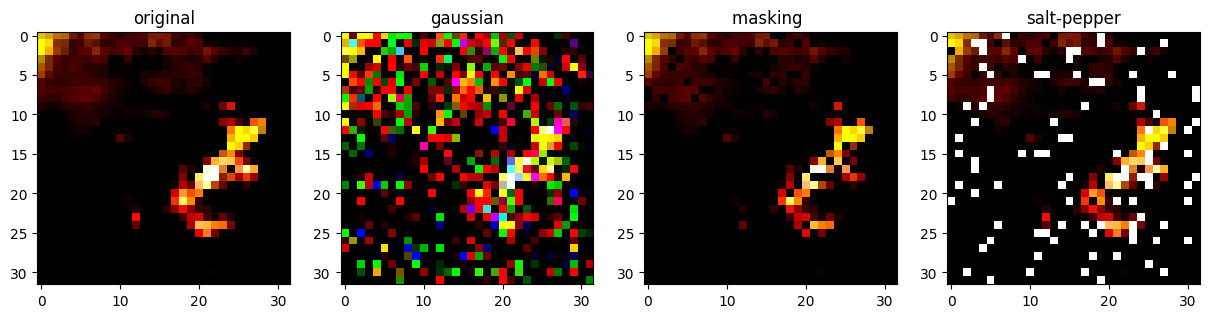

In [55]:
# show noisy images
test,_ = next(iter(train_loader))
test=test[9]

fig, axes=plt.subplots(1,4,figsize=(15,15))
axes[0].imshow(test.permute(1,2,0).squeeze())
axes[0].set_title("original")
noise = GaussianNoise()
axes[1].imshow(noise(test).permute(1,2,0).squeeze())
axes[1].set_title("gaussian")
noise = MaskingNoise(prob=0.2)
axes[2].imshow(noise(test).permute(1,2,0))
axes[2].set_title("masking ")
noise = SaltPepperNoise(prob=0.2)
axes[3].imshow(noise(test).permute(1,2,0))
axes[3].set_title("salt-pepper")

In [71]:
# DAE class

class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoencoder, self).__init__()

    base_model = resnet18(weights=None)
    base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    base_model.maxpool = nn.Identity()  # Remove unnecessary max pooling
    base_model.fc = nn.Identity()  # Remove classification layer
    self.encoder = nn.Sequential(
      base_model,
      nn.Flatten(),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2)
    )

    self.decoder = nn.Sequential(
      nn.Linear(256, 256 * 4 * 4),
      nn.ReLU(),
      nn.Unflatten(dim=1, unflattened_size=(256, 4, 4)),
      nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
      nn.InstanceNorm2d(128),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
      nn.InstanceNorm2d(64),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1)
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [87]:
def add_noise(batch):
  noisy_batch = torch.stack([noise(img) for img in batch])
  return noisy_batch

def train_dae(model, train_loader, val_loader, noise, num_epochs=10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss = []
  val_loss = []
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, clean_images, _ in train_loader:
      images=images.to(device)
      clean_images=clean_images.to(device)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, clean_images)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    tl = running_loss/len(train_loader)
    train_loss.append(tl)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
      for images, clean_images, _ in val_loader:
        images = images.to(device)
        clean_images = clean_images.to(device)
        reconstructed = model(images)
        loss = criterion(reconstructed, clean_images)
        running_loss += loss.item()

      vl = running_loss/len(test_loader)
      val_loss.append(vl)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {tl:.4f}, Validation Loss: {vl:.4f}")

  return model, train_loss, val_loss

def visualize_results(train_loss, val_loss):
  plt.figure(figsize=(14, 6))
  plt.subplot(1,2,1)
  plt.plot(train_loss)
  plt.xlabel("iteration")
  plt.ylabel("train loss")
  plt.title("training loss")
  plt.subplot(1,2,2)
  plt.plot(val_loss)
  plt.xlabel("iteration")
  plt.ylabel("val loss")
  plt.title("validation loss")
  plt.show()

def view_reconstruction(model, val_loader, noise_model):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  val_images_noisy, val_images, _ = next(iter(val_loader))
  val_images_noisy = val_images_noisy.to(device)

  with torch.no_grad():
    reconstructed_images = model(val_images_noisy)

  val_images_noisy = val_images_noisy.cpu().numpy()
  reconstructed_images = reconstructed_images.cpu().numpy()
  fig, axes = plt.subplots(2, 4, figsize=(12, 8))
  for i in range(4):
    axes[0, i].imshow(val_images[i].permute(1,2,0).squeeze(), cmap="gray")
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(np.transpose(reconstructed_images[i],(1,2,0)), cmap="gray")
    axes[1, i].set_title("Noisy Reconstruction")
    axes[1, i].axis("off")

  plt.show()

Training with Gaussian noise...
Epoch 1/10, Loss: 0.8884, Validation Loss: 0.3073
Epoch 2/10, Loss: 0.5777, Validation Loss: 0.2685
Epoch 3/10, Loss: 0.4520, Validation Loss: 0.2115
Epoch 4/10, Loss: 0.3840, Validation Loss: 0.1883
Epoch 5/10, Loss: 0.3528, Validation Loss: 0.1695
Epoch 6/10, Loss: 0.3301, Validation Loss: 0.1612
Epoch 7/10, Loss: 0.3192, Validation Loss: 0.1557
Epoch 8/10, Loss: 0.3024, Validation Loss: 0.1518
Epoch 9/10, Loss: 0.2951, Validation Loss: 0.1500
Epoch 10/10, Loss: 0.2841, Validation Loss: 0.1488


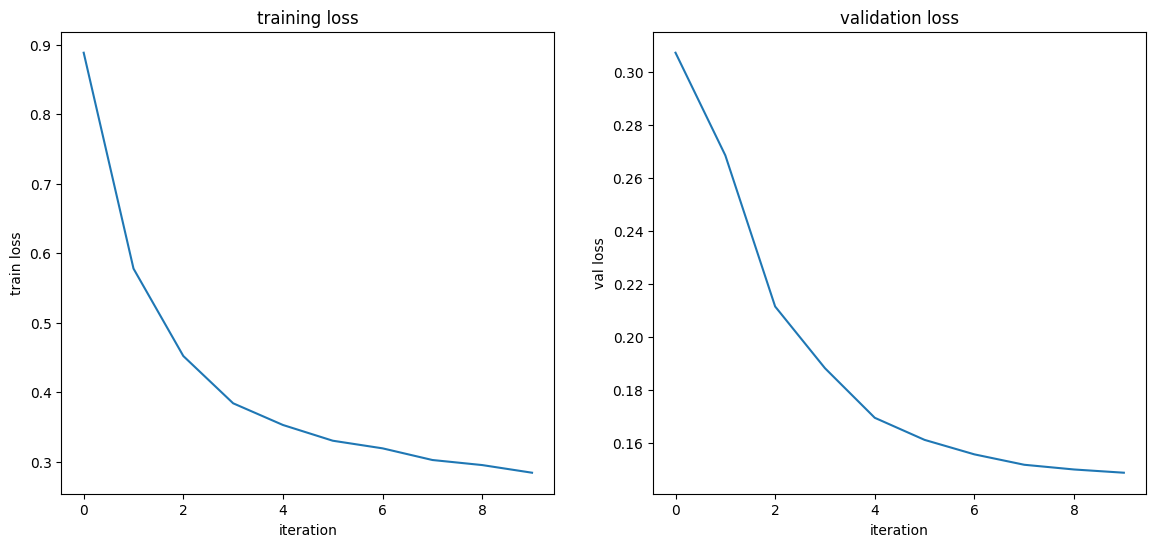

In [77]:
gaussian = GaussianNoise(0, 0.01)
model = DenoisingAutoencoder()
cifar100_train_gaussian = NoisyDataset('./data', train=True, download=True, transform=transform, noise_model=gaussian)
train_loader_100 = DataLoader(cifar100_train_gaussian, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
val_loader_noisy = DataLoader(cifar100_train_gaussian, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))

print('Training with Gaussian noise...')
model, gaussian_train_loss, gaussian_val_loss = train_dae(model, train_loader_100, val_loader_noisy, gaussian, num_epochs=75)
visualize_results(gaussian_train_loss, gaussian_val_loss)

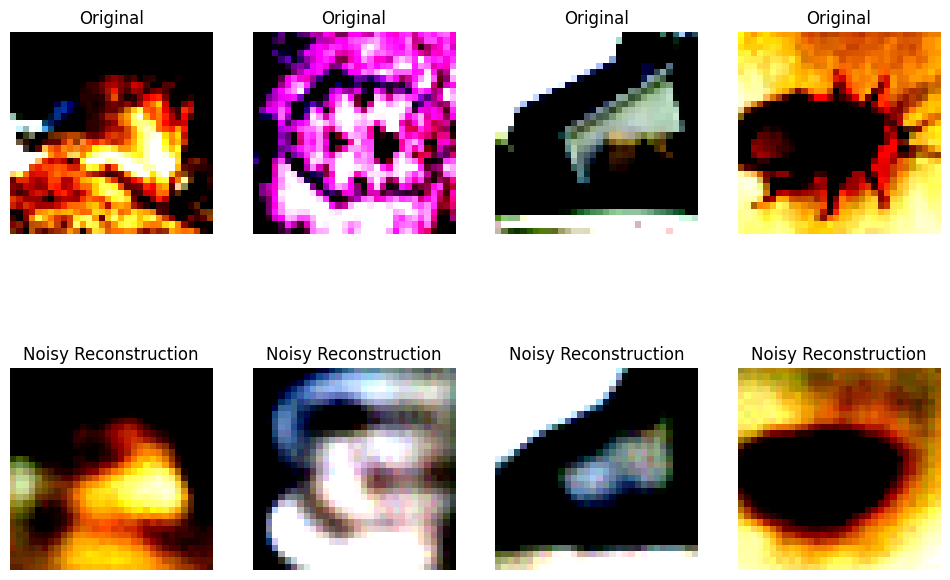

In [88]:
view_reconstruction(model, val_loader_noisy, gaussian)

In [ ]:
masking = MaskingNoise(0.2, mean, std)
model = DenoisingAutoencoder()
cifar100_train_masking = NoisyDataset('./data', train=True, download=True, transform=transform, noise_model=masking)
train_loader_100 = DataLoader(cifar100_train_masking, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
val_loader_noisy = DataLoader(cifar100_train_masking, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))
print('Training with Masking noise...')
model, masking_train_loss, masking_val_loss = train_dae(model, train_loader_100, val_loader_noisy, masking, num_epochs=75)
visualize_results(masking_train_loss, masking_val_loss)

In [ ]:
view_reconstruction(model, val_loader_noisy, masking)

In [ ]:
salt_pepper = SaltPepperNoise(0.2, mean, std)
model = DenoisingAutoencoder()
cifar100_train_sp = NoisyDataset('./data', train=True, download=True, transform=transform, noise_model=salt_pepper)
train_loader_100 = DataLoader(cifar100_train_sp, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
val_loader_noisy = DataLoader(cifar100_train_sp, batch_size=128, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN + NUM_VAL)))
print('Training with Salt-Pepper noise...')
model, salt_pepper_train_loss, salt_pepper_val_loss = train_dae(model, train_loader_100, val_loader_noisy, salt_pepper, num_epochs=75)
visualize_results(salt_pepper_train_loss, salt_pepper_val_loss)

In [ ]:
view_reconstruction(model, val_loader_noisy, salt_pepper)